In [1]:
import optuna
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

d:\Programas\miniconda3\envs\m3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Programas\miniconda3\envs\m3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
!pip install kaleido
!pip install nbformat

^C


## Optuna plots

In [3]:
fname = './study_20230129-001603.pkl'
study = pickle.load(open(fname,'rb'))
os.makedirs('optuna-vis', exist_ok=True)


In [4]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image('./optuna-vis/importance.png')
fig

In [6]:
fig = optuna.visualization.plot_contour(study, params = ['learning_rate', 'dropout', 'regularizer', 'batch_norm', 'freeze_from', 'freeze_percent'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.write_image('./optuna-vis/contours.png')
fig

[W 2023-01-29 00:21:06,145] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,146] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,147] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,149] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,150] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,151] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,152] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,153] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,154] Param regularizer unique value length is less than 2.
[W 2023-01-29 00:21:06,154] Param regularizer unique value length is less than 2.


## Qualitative analysis

In [2]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from src.model import build_xception_model # Aquí hauràs d'importar la funció del model que facis servir

data_dir = './data/MIT_split/test'
batch_size = 32
image_size = (224, 224)

# create an ImageDataGenerator for the test data
prep = keras.applications.xception.preprocess_input
test_datagen = ImageDataGenerator(preprocessing_function=prep)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


model = build_xception_model(weights = './out/model_weights/xception_20230128-221841.h5')

# make predictions on the test data
test_steps = test_generator.n // batch_size
predictions = model.predict(test_generator, steps=test_steps)


Found 807 images belonging to 8 classes.
25/25 [==============================] - 7s 160ms/step


In [23]:
def plot_predictions(predictions, images, labels, classes, class_names, n=10, only_correct=False, only_incorrect=False, class_index=0):
    # get the number of rows needed to plot all images
    rows = (n + 4) // 5
    # create a figure and axis
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    # flatten the axis array
    axes = axes.ravel()

    correct_indices = np.where((np.argmax(predictions, axis=-1) == np.argmax(labels, axis=-1)) & (classes == class_index))[0]
    incorrect_indices = np.where((np.argmax(predictions, axis=-1) != np.argmax(labels, axis=-1)) & (classes == class_index))[0]
    
    if only_correct:
        indices = np.random.choice(correct_indices, min(n, len(correct_indices)), replace=False)
    elif only_incorrect:
        indices = np.random.choice(incorrect_indices, min(n, len(incorrect_indices)), replace=False)
    else:
        indices = np.random.choice(range(len(images)), min(n, len(images)), replace=False)
        
    images = images[indices]
    labels = labels[indices]
    predictions = predictions[indices]
    # plot the images
    for i in range(len(indices)):
        # get the i-th image and its corresponding prediction
        img = images[i].astype(np.uint8)
        prediction = np.argmax(predictions[i])

        # plot the image on the i-th subplot
        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {class_names[prediction]}\nActual: {class_names[np.argmax(labels[i])]}')
        axes[i].axis('off')

    # remove the remaining subplots
    for i in range(len(indices), len(axes)):
        axes[i].remove()

    plt.show()


In [6]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    data_dir,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

images, labels = [], []

for data, label in test_generator:
    images.append(data)
    labels.append(label)

    if len(images) == len(predictions):
        break

Found 807 images belonging to 8 classes.


In [7]:
# concatenate the batches of images and labels
images_concat = np.concatenate(images)
labels_concat = np.concatenate(labels)
classes = test_generator.classes[:len(predictions)]
class_names = list(test_generator.class_indices.keys())

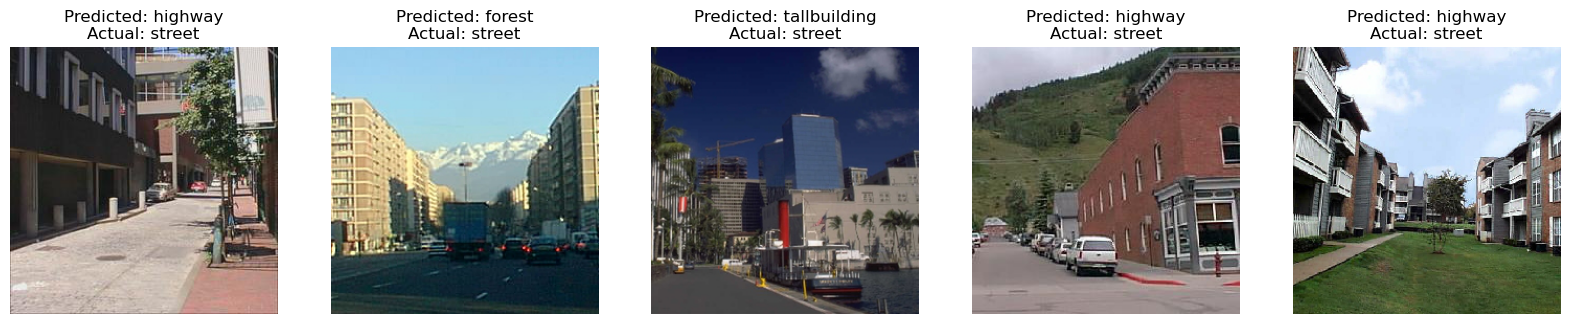

In [47]:
plot_predictions(predictions, images_concat, labels_concat, classes, class_names, n=5, only_incorrect=True, class_index=6)

## Layer analysis

In [78]:
from math import ceil
from keras.layers import Conv2D
from keras.models import Model

def get_intermediate_layer_model(model, layer_index: int = -1) -> Model:
    """
    Returns the intermediate layers model from a given model. 

    Args:
        model (Sequential): Keras model.
        layer_name (int): Index of the layer to be returned.
    """
    intermediate_layer_model = Model(inputs=model.input,
                                        outputs=model.layers[layer_index].output)
    return intermediate_layer_model


def visualize_layer(model, sample, conv_index=None, aggr='Max'):
    conv_layers = [i for i, layer in enumerate(model.layers) if 'conv' in layer.name]
    if conv_index is not None:
        if conv_index < 0:
            conv_index = len(conv_layers) + conv_index
        feature_model = get_intermediate_layer_model(model, conv_layers[conv_index])
        feature_maps = feature_model.predict(sample)
        feature_maps = feature_maps[0]

        if aggr == 'Max':
            layer_output = np.max(feature_maps, axis=-1)
        elif aggr == 'Avg':
            layer_output = np.average(feature_maps, axis=-1)
        elif aggr == 'Sum':
            layer_output = np.sum(feature_maps, axis=-1)
        else:
            raise ValueError('Invalid aggregation method')

        plt.figure(figsize=(4, 4))
        plt.imshow(layer_output)
    else:
        num_rows = ceil(len(conv_layers) / 10)
        plt.figure(figsize=(16, 2*num_rows))
        for i, layer_index in enumerate(conv_layers):
            feature_model = get_intermediate_layer_model(model, layer_index)
            feature_maps = feature_model.predict(sample)
            feature_maps = feature_maps[0]
            if aggr == 'Max':
                layer_output = np.max(feature_maps, axis=-1)
            elif aggr == 'Avg':
                layer_output = np.average(feature_maps, axis=-1)
            elif aggr == 'Sum':
                layer_output = np.sum(feature_maps, axis=-1)
            else:
                raise ValueError('Invalid aggregation method')

            plt.subplot(num_rows, 10, i+1)
            plt.imshow(layer_output)
            plt.axis('off')
            plt.title(f'Layer {layer_index}')

1/1 [==============================] - 0s 169ms/step


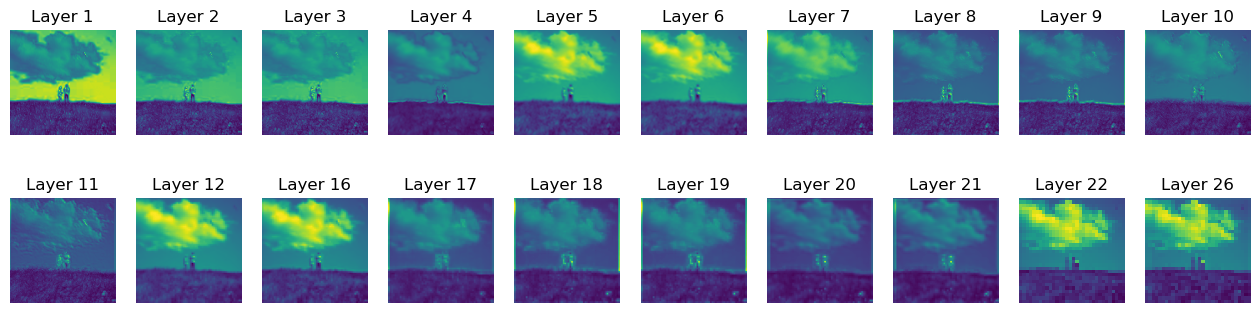

In [79]:
sample = images_concat[0][None, ...]
visualize_layer(model, sample, conv_index=None, aggr="Max")